Imports And Init

In [1]:
from datetime import datetime
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
import json
import mysql.connector
import ast

db_config = {
    'host': '150.140.186.118',
    'port': 3306,
    'user': 'readonly_student',
    'password': 'iot_password',
    'database': 'default'
}


Fetch Data

In [2]:
def fetch_data(table_name, attr_name, start_datetime=None, end_datetime=None):
    
    try:
        # Establish the connection to the database
        connection = mysql.connector.connect(**db_config)
        cursor = connection.cursor()

        query = f"""
            SELECT 
                R1.attrValue AS timestamp,
                R2.attrValue AS location, 
                R4.attrValue AS acc_x, 
                R5.attrValue AS acc_y, 
                R6.attrValue AS acc_z,
                R7.attrValue AS speed,
                R8.attrValue AS altitude
            FROM 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R1 
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R2 
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R4 
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R5  
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R6
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R7
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R8
            ON 
                R1.recvTimeTs = R2.recvTimeTs AND
                R1.recvTimeTs = R4.recvTimeTs AND
                R1.recvTimeTs = R5.recvTimeTs AND
                R1.recvTimeTs = R6.recvTimeTs AND
                R1.recvTimeTs = R7.recvTimeTs AND
                R1.recvTimeTs = R8.recvTimeTs AND
                R2.recvTimeTs = R4.recvTimeTs AND
                R2.recvTimeTs = R5.recvTimeTs AND
                R2.recvTimeTs = R6.recvTimeTs AND
                R2.recvTimeTs = R7.recvTimeTs AND
                R2.recvTimeTs = R8.recvTimeTs AND
                R4.recvTimeTs = R5.recvTimeTs AND
                R4.recvTimeTs = R6.recvTimeTs AND
                R4.recvTimeTs = R7.recvTimeTs AND
                R4.recvTimeTs = R8.recvTimeTs AND
                R5.recvTimeTs = R6.recvTimeTs AND
                R5.recvTimeTs = R7.recvTimeTs AND
                R5.recvTimeTs = R8.recvTimeTs AND
                R6.recvTimeTs = R7.recvTimeTs AND
                R6.recvTimeTs = R8.recvTimeTs
            WHERE 
                R1.attrName = "date" AND 
                R2.attrName = "location" AND
                R4.attrName = "accx" AND 
                R5.attrName = "accy" AND 
                R6.attrName = "accz" AND
                R7.attrName=  "speed" AND
                R8.attrName=  "altitude";
        """
        
        # Define parameters for the query
        # params = attr_name

        cursor.execute(query)

        # Fetch and return the results
        results = cursor.fetchall()
        json_results = []
        for row in results:
            # json_result = process_data(row)
            json_results.append(row)
        return json_results

    except mysql.connector.Error as err:
        print(f"Error: {err}")

    finally:
        # Close the cursor and connection
        if cursor:
            cursor.close()
        if connection:
            connection.close()

In [3]:
data=fetch_data("AutoSenseAnalytics_IMU_Measurement_raw", "timestamp","2025-02-09T15:55:22.000Z","2025-02-09T16:31:02.000Z")
print(data[3])

('2025-02-09T15:55:30.000Z', '{"type":"Point","coordinates":[38.243356,21.725677]}', '[0.083984375,0.087890625,0.083984375,0.089355469,0.087890625,0.083984375,0.084716797,0.091552734,0.083740234,0.082275391,0.082519531,0.082275391,0.090332031,0.086425781,0.089355469,0.086669922,0.085693359,0.088378906,0.078369141,0.086425781,0.087402344,0.090576172,0.088134766,0.087402344,0.088867188,0.078125,0.092529297,0.084960938,0.087158203,0.084472656,0.094726562,0.091064453,0.0859375,0.081298828,0.082763672,0.084716797,0.08203125]', '[-0.343994141,-0.344726562,-0.337646484,-0.338867188,-0.341064453,-0.345458984,-0.339111328,-0.336425781,-0.342285156,-0.342041016,-0.334716797,-0.339111328,-0.340087891,-0.335449219,-0.339599609,-0.338378906,-0.338867188,-0.338134766,-0.339599609,-0.333496094,-0.345214844,-0.34765625,-0.333251953,-0.339355469,-0.341064453,-0.354492188,-0.343994141,-0.339111328,-0.341064453,-0.338623047,-0.342041016,-0.338623047,-0.342041016,-0.340820312,-0.336914062,-0.341064453,-0.

In [4]:
acc_x=[]
acc_y=[]
acc_z=[]
latitude=[]
longitude=[]
speed=[]
altitude=[]
timestamp=[]
for i in data:
    timestamp.append(i[0])
    latitude.append(json.loads(i[1])['coordinates'][0])
    longitude.append(json.loads(i[1])['coordinates'][1])
    acc_x.append(i[2])
    acc_y.append(i[3])
    acc_z.append(i[4])
    speed.append(i[5])
    altitude.append(i[6])


In [5]:
#fix the format '[]' to []
acc_x_proc= [ast.literal_eval(item) for item in acc_x]
acc_y_proc= [ast.literal_eval(item) for item in acc_y]
acc_z_proc= [ast.literal_eval(item) for item in acc_z]


In [11]:
print(acc_z_proc[0])

[]


In [ ]:
import matplotlib.pyplot as plt

def calc_rough_score(acc_list):
    # Define sample rate (assuming 10 Hz, meaning 0.1s intervals)
    sampling_rate = 20  # Hz (adjust based on actual sampling rate)
    n = len(acc_list)  # Number of samples

    # Compute FFT
    fft_values = np.fft.fft(acc_list)
    fft_magnitudes = np.abs(fft_values)  # Get magnitude (strength) of each frequency
    frequencies = np.fft.fftfreq(n, d=1/sampling_rate)  # Get corresponding frequency bins

    # Keep only the positive half of frequencies (since FFT is symmetric)
    positive_freqs = frequencies[:n//2]
    positive_magnitudes = fft_magnitudes[:n//2]

    # plt.figure(figsize=(10,5))
    # plt.plot(positive_freqs, positive_magnitudes, marker='o')
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Magnitude")
    # plt.title("Frequency Spectrum of Acceleration Data")
    # plt.grid()
    # plt.show()

    roughness_score = np.sum(positive_magnitudes[positive_freqs > 5])  # Adjust threshold if needed
    print("Road Roughness Score:", roughness_score)
    return roughness_score

scores=[]
for i in acc_z_proc:
    if len(i) == 0:
        scores.append(0)
        continue

    score=calc_rough_score(i)
    scores.append(score)

print(scores)   

Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughness Score: 0.0
Road Roughne

In [9]:
import numpy as np

# Calculate the standard deviation for each sublist in acc_x, acc_y, and acc_z
acc_x_std = []
acc_y_std = []
acc_z_std = []

for i in acc_x_proc:
    if len(i) == 0:
        acc_x_std.append(0)
        continue
    acc_x_std.append(np.std(i))

for i in acc_y_proc:
    if len(i) == 0:
        acc_y_std.append(0)
        continue
    acc_y_std.append(np.std(i))

for i in acc_z_proc:
    if len(i) == 0:
        acc_z_std.append(0)
        continue
    acc_z_std.append(np.std(i))

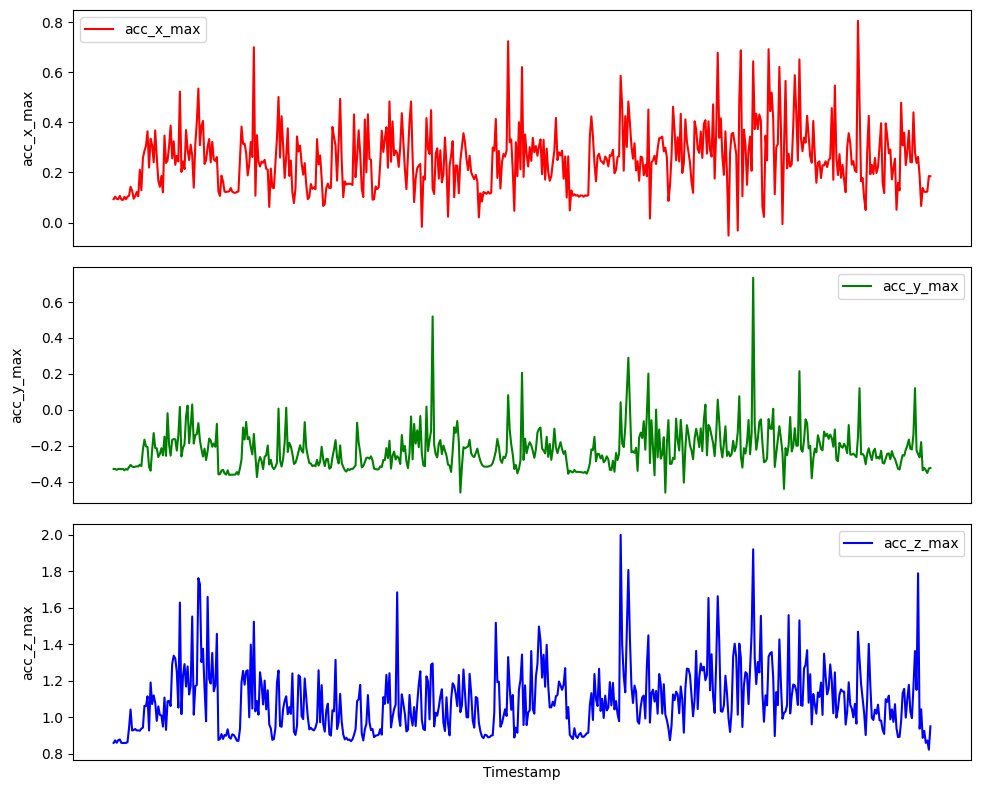

In [ ]:
#plot the avg of acc_x
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot acc_x_avg
axs[0].plot(timestamp[1:], acc_x_max[1:], label='acc_x_max', color='r')
axs[0].set_ylabel('acc_x_max')
axs[0].legend()

# Plot acc_y_avg
axs[1].plot(timestamp[1:], acc_y_max[1:], label='acc_y_max', color='g')
axs[1].set_ylabel('acc_y_max')
axs[1].legend()

# Plot acc_z_avg
axs[2].plot(timestamp[1:], acc_z_max[1:], label='acc_z_max', color='b')
axs[2].set_ylabel('acc_z_max')
axs[2].legend()

plt.xlabel('Timestamp')
plt.xticks([])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

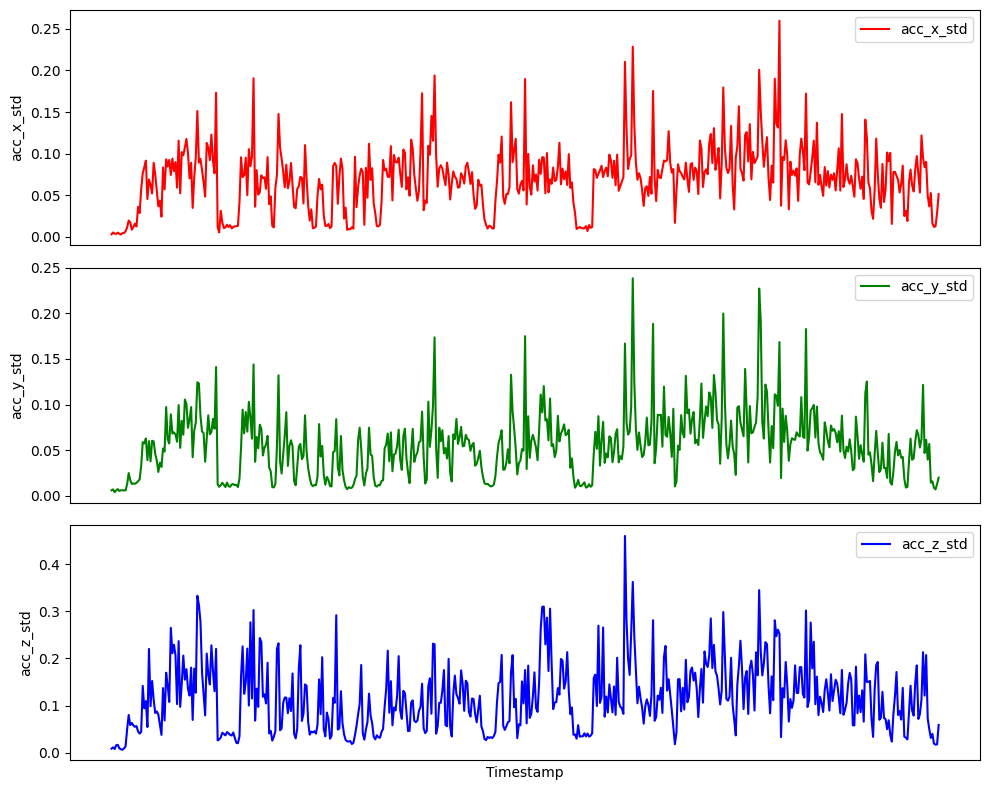

In [9]:
#plot the avg of acc_x
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot acc_x_avg
axs[0].plot(timestamp[1:], acc_x_std[1:], label='acc_x_std', color='r')
axs[0].set_ylabel('acc_x_std')
axs[0].legend()

# Plot acc_y_avg
axs[1].plot(timestamp[1:], acc_y_std[1:], label='acc_y_std', color='g')
axs[1].set_ylabel('acc_y_std')
axs[1].legend()

# Plot acc_z_avg
axs[2].plot(timestamp[1:], acc_z_std[1:], label='acc_z_std', color='b')
axs[2].set_ylabel('acc_z_std')
axs[2].legend()

plt.xlabel('Timestamp')
plt.xticks([])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

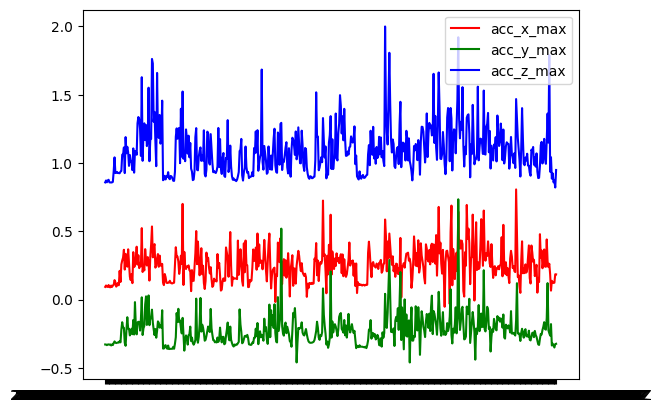

In [9]:
plt.plot(timestamp[1:], acc_x_max[1:], label='acc_x_max', color='r')
plt.plot(timestamp[1:], acc_y_max[1:], label='acc_y_max', color='g')
plt.plot(timestamp[1:], acc_z_max[1:], label='acc_z_max', color='b')
plt.legend(loc='upper right')
plt.show()


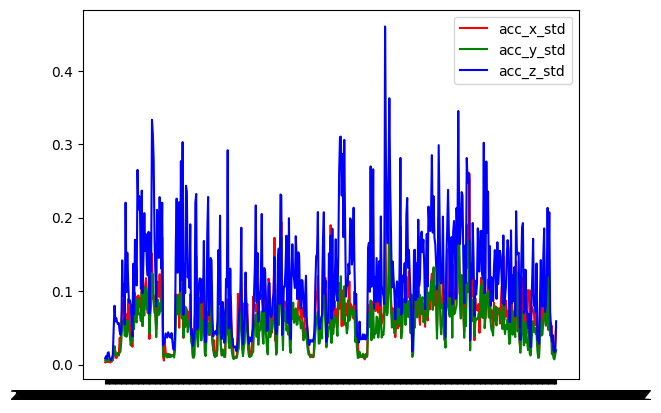

In [10]:
plt.plot(timestamp[1:], acc_x_std[1:], label='acc_x_std', color='r')
plt.plot(timestamp[1:], acc_y_std[1:], label='acc_y_std', color='g')
plt.plot(timestamp[1:], acc_z_std[1:], label='acc_z_std', color='b')
plt.legend(loc='upper right')
plt.show()


Post it to influx

In [10]:
def process_data(timestamp, latitude,longitude, acc_x_avg, acc_y_avg, acc_z_avg, speed, altitude):
    try:
        return {
            'timestamp': timestamp,
            'latitude': latitude,
            'longitude': longitude,
            'acc_x_max': acc_x_max,
            'acc_y_max': acc_y_max,
            'acc_z_max': acc_z_max,
            'speed': speed,
            'altitude': altitude
        }
    except Exception as e:
        print(f"Error: {e}")
        return None

print(timestamp[1], latitude[1],longitude[1], acc_x_max[1], acc_y_max[1], acc_z_max[1], speed[1], altitude[1])


2025-02-09T15:55:22.000Z 38.243356 21.725635 0.093261719 -0.328369141 0.858398438 0 -4.9


In [11]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

# InfluxDB connection details
influxdb_url = "http://150.140.186.118:8086"
bucket = "AutoSenseAnalytics_imu_max"
org = "students"
token = "F5O5OXY9OQiNpKg9vjThGSsHoRGg_Pkt-vSyjt-wxg87WEv_054lUqLYmfzakjgKYgJsi027QoXSd5X6SsYhKQ=="



In [12]:
points=[]
for i in range(1,len(timestamp)):
    point= Point("imu_avg")\
            .field("acc_x_max", acc_x_max[i])\
            .field("acc_y_max", acc_y_max[i])\
            .field("acc_z_max", acc_z_max[i])\
            .field("speed", float(speed[i]))\
            .field("altitude", float(altitude[i]))\
            .field("latitude", float(latitude[i]))\
            .field("longitude", float(longitude[i]))\
            .time(timestamp[i])
    points.append(point)

client = InfluxDBClient(url=influxdb_url, token=token, org=org)
try:
    write_api = client.write_api(write_options=SYNCHRONOUS)
    write_api.write(bucket=bucket, org=org, record=points)
    write_api.flush()
finally:
    client.close()
    print("InfluxDB updated successfully")


InfluxDB updated successfully
